# Give Me Some Credit Dataset Analysis

## Dataset Overview
- **Source**: "Give Me Some Credit" Kaggle Competition Dataset
- **Records**: 150,000 borrower records
- **Target**: Binary credit risk assessment (6.7% default rate)
- **Features**: 10 original features + engineered features

## Data Preprocessing
- Missing value imputation (MonthlyIncome: median, NumberOfDependents: mode)
- Outlier capping for extreme values
- Feature scaling for distance-based algorithms

## Feature Engineering
- Age-based risk segmentation
- Credit utilization analysis
- Delinquency pattern indicators
- Financial stress metrics
- Composite risk scoring

## Modeling Approach
- Multiple ML algorithms: Logistic Regression, Decision Tree, Random Forest, XGBoost, LightGBM
- Class imbalance handling with balanced weights
- 80-20 stratified train-test split
- Evaluation metrics: F1-Score, AUC-ROC, Precision, Recall

In [1]:
import pandas as pd

train = pd.read_csv('/Users/misanmeggison/uc-credit-risk/Give Credit/cs-training.csv')
test = pd.read_csv('/Users/misanmeggison/uc-credit-risk/Give Credit/cs-training.csv')

In [2]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

print("Dataset Overview:")
print(f"Training shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Basic info
print(f"\nBasic Information:")
print(f"Total records: {len(train):,}")
print(f"Features: {train.shape[1] - 1}")

# Target analysis - detect target column
target_col = None
for col in train.columns:
    if train[col].dtype in ['int64', 'float64']:
        unique_vals = train[col].dropna().unique()
        if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
            target_col = col
            break

if target_col:
    target = train[target_col]
    print(f"\nTarget Variable: '{target_col}'")
    print(f"No default (0): {(target == 0).sum():,} ({(target == 0).mean():.1%})")
    print(f"Default (1): {(target == 1).sum():,} ({(target == 1).mean():.1%})")

# Missing values
missing_data = train.isnull().sum()
missing_data = missing_data[missing_data > 0]
if len(missing_data) > 0:
    print(f"\nMissing Values:")
    for col, count in missing_data.items():
        print(f"{col}: {count:,} ({(count/len(train))*100:.1f}%)")

train.head()

Dataset Overview:
Training shape: (150000, 12)
Test shape: (150000, 12)

Basic Information:
Total records: 150,000
Features: 11

Target Variable: 'SeriousDlqin2yrs'
No default (0): 139,974 (93.3%)
Default (1): 10,026 (6.7%)

Missing Values:
MonthlyIncome: 29,731 (19.8%)
NumberOfDependents: 3,924 (2.6%)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
# Data Cleaning and Feature Engineering
df = train.copy()

# Remove ID column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

print(f"Working dataset shape: {df.shape}")

# Handle missing values
if 'MonthlyIncome' in df.columns:
    income_median = df['MonthlyIncome'].median()
    df['MonthlyIncome'].fillna(income_median, inplace=True)
    print(f"MonthlyIncome: Filled with median ${income_median:,.0f}")

if 'NumberOfDependents' in df.columns:
    dependents_mode = df['NumberOfDependents'].mode().iloc[0]
    df['NumberOfDependents'].fillna(dependents_mode, inplace=True)
    print(f"NumberOfDependents: Filled with mode {dependents_mode}")

# Handle outliers
if 'RevolvingUtilizationOfUnsecuredLines' in df.columns:
    df.loc[df['RevolvingUtilizationOfUnsecuredLines'] > 2, 'RevolvingUtilizationOfUnsecuredLines'] = 2

if 'DebtRatio' in df.columns:
    debt_99th = df['DebtRatio'].quantile(0.99)
    df.loc[df['DebtRatio'] > debt_99th, 'DebtRatio'] = debt_99th

# Feature Engineering
print("\nFeature Engineering:")

# Age groups
if 'age' in df.columns:
    df['age_young'] = (df['age'] < 25).astype(int)
    df['age_senior'] = (df['age'] > 65).astype(int)
    df['age_prime'] = ((df['age'] >= 25) & (df['age'] <= 50)).astype(int)

# Income levels
if 'MonthlyIncome' in df.columns:
    df['high_income'] = (df['MonthlyIncome'] > df['MonthlyIncome'].quantile(0.75)).astype(int)
    df['low_income'] = (df['MonthlyIncome'] < df['MonthlyIncome'].quantile(0.25)).astype(int)

# Credit utilization
if 'RevolvingUtilizationOfUnsecuredLines' in df.columns:
    df['high_utilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] > 0.8).astype(int)
    df['maxed_out'] = (df['RevolvingUtilizationOfUnsecuredLines'] >= 0.95).astype(int)
    df['no_utilization'] = (df['RevolvingUtilizationOfUnsecuredLines'] == 0).astype(int)

# Delinquency features
late_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']
existing_late_cols = [col for col in late_cols if col in df.columns]

if existing_late_cols:
    df['any_delinquency'] = (df[existing_late_cols].sum(axis=1) > 0).astype(int)
    df['severe_delinquency'] = (df['NumberOfTimes90DaysLate'] > 0).astype(int) if 'NumberOfTimes90DaysLate' in df.columns else 0
    df['total_delinquencies'] = df[existing_late_cols].sum(axis=1)

# Financial stress
if all(col in df.columns for col in ['DebtRatio', 'MonthlyIncome']):
    df['debt_stress'] = (df['DebtRatio'] > 0.4).astype(int)

# Credit portfolio
credit_cols = ['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
existing_credit_cols = [col for col in credit_cols if col in df.columns]

if existing_credit_cols:
    df['total_credit_lines'] = df[existing_credit_cols].sum(axis=1)
    df['thin_file'] = (df['total_credit_lines'] < 5).astype(int)

# Composite risk score
risk_factors = ['any_delinquency', 'high_utilization', 'debt_stress', 'thin_file']
risk_factors = [f for f in risk_factors if f in df.columns]
if risk_factors:
    df['risk_score'] = df[risk_factors].sum(axis=1)

print(f"Final shape: {df.shape}")
print(f"Added {df.shape[1] - train.shape[1]} new features")
print("Data preprocessing complete!")

Working dataset shape: (150000, 11)
MonthlyIncome: Filled with median $5,400
NumberOfDependents: Filled with mode 0.0

Feature Engineering:
Final shape: (150000, 26)
Added 14 new features
Data preprocessing complete!


Overall default rate: 6.7%


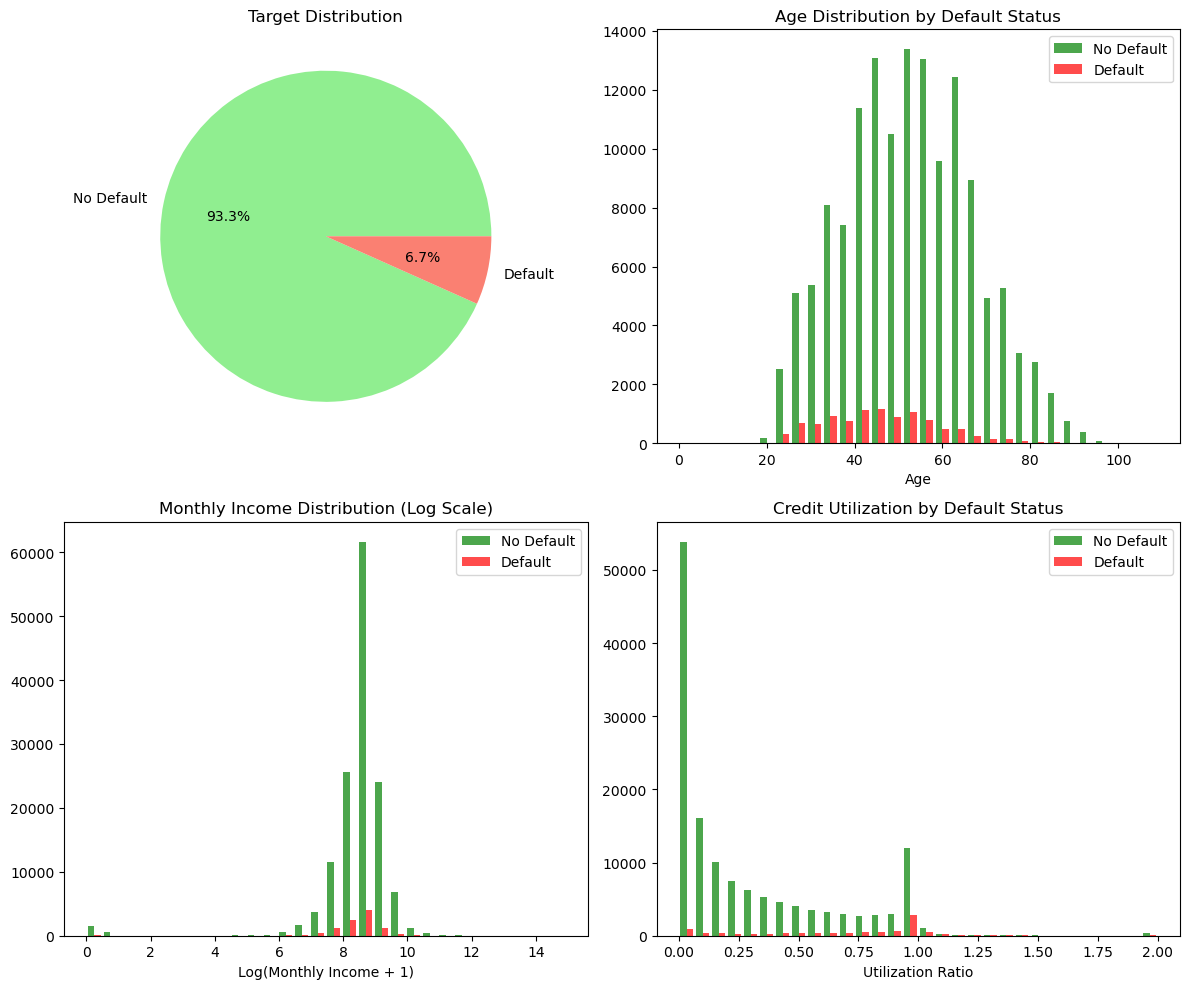

In [5]:
# Basic Data Distribution Analysis
target = df['SeriousDlqin2yrs']
print(f"Overall default rate: {target.mean():.1%}")

# Create subsets for analysis
df_no_default = df[df['SeriousDlqin2yrs'] == 0]
df_default = df[df['SeriousDlqin2yrs'] == 1]

# Visualization 1: Target and Basic Distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Target distribution
ax1 = axes[0, 0]
target_counts = target.value_counts()
ax1.pie(target_counts.values, labels=['No Default', 'Default'], autopct='%1.1f%%', 
        colors=['lightgreen', 'salmon'])
ax1.set_title('Target Distribution')

# Age distribution
ax2 = axes[0, 1]
ax2.hist([df_no_default['age'], df_default['age']], bins=30, alpha=0.7, 
         label=['No Default', 'Default'], color=['green', 'red'])
ax2.set_title('Age Distribution by Default Status')
ax2.set_xlabel('Age')
ax2.legend()

# Monthly Income (log scale)
ax3 = axes[1, 0]
ax3.hist([np.log1p(df_no_default['MonthlyIncome']), np.log1p(df_default['MonthlyIncome'])], 
         bins=30, alpha=0.7, label=['No Default', 'Default'], color=['green', 'red'])
ax3.set_title('Monthly Income Distribution (Log Scale)')
ax3.set_xlabel('Log(Monthly Income + 1)')
ax3.legend()

# Revolving Utilization
ax4 = axes[1, 1]
ax4.hist([df_no_default['RevolvingUtilizationOfUnsecuredLines'], 
          df_default['RevolvingUtilizationOfUnsecuredLines']], 
         bins=30, alpha=0.7, label=['No Default', 'Default'], color=['green', 'red'])
ax4.set_title('Credit Utilization by Default Status')
ax4.set_xlabel('Utilization Ratio')
ax4.legend()

plt.tight_layout()
plt.show()

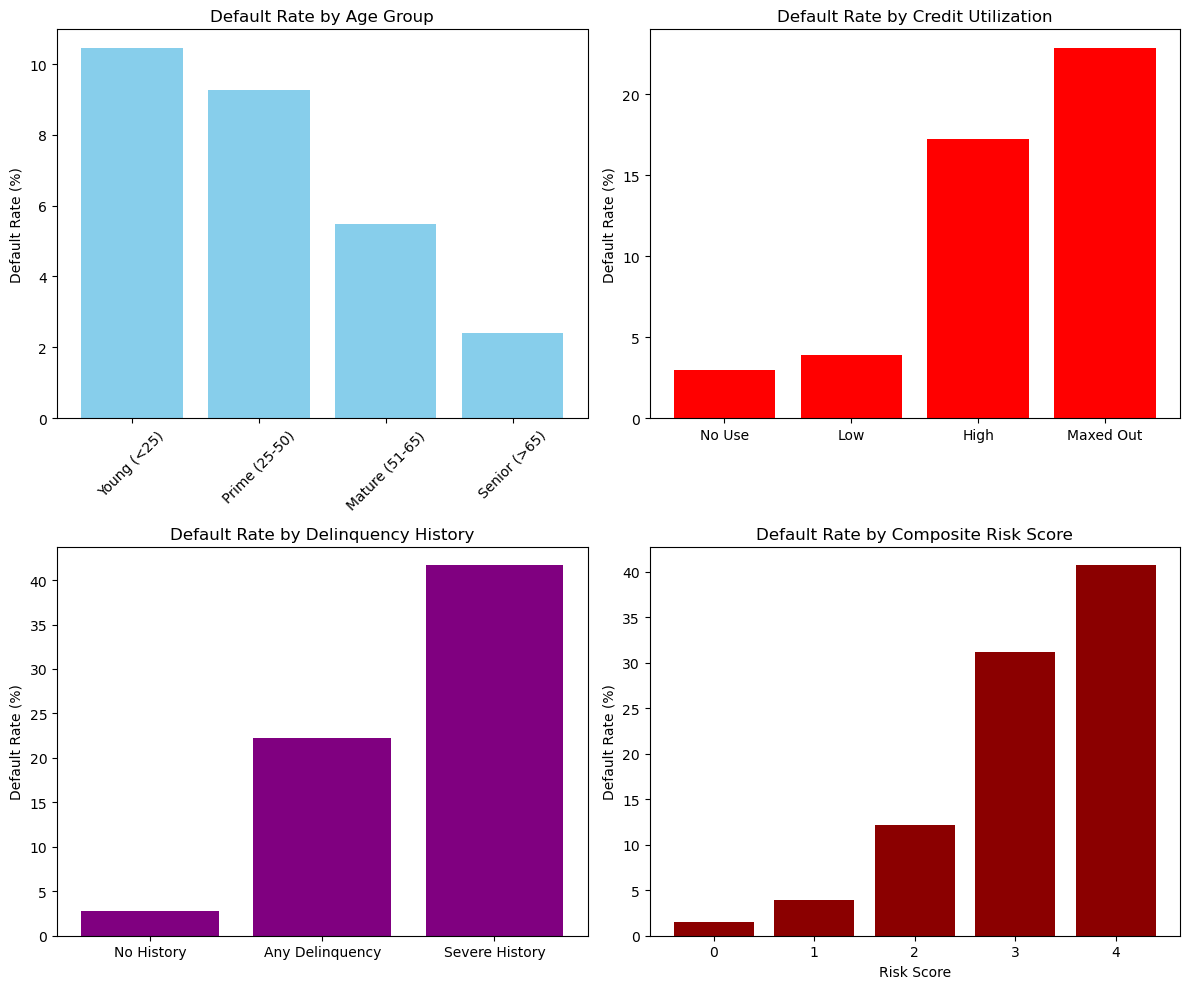

In [6]:
# Risk Factor Analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Default rate by age groups
ax1 = axes[0, 0]
age_groups = ['Young (<25)', 'Prime (25-50)', 'Mature (51-65)', 'Senior (>65)']
age_defaults = [
    df[df['age_young'] == 1]['SeriousDlqin2yrs'].mean(),
    df[df['age_prime'] == 1]['SeriousDlqin2yrs'].mean(), 
    df[(df['age'] > 50) & (df['age'] <= 65)]['SeriousDlqin2yrs'].mean(),
    df[df['age_senior'] == 1]['SeriousDlqin2yrs'].mean()
]
ax1.bar(range(len(age_groups)), [rate * 100 for rate in age_defaults], color='skyblue')
ax1.set_title('Default Rate by Age Group')
ax1.set_ylabel('Default Rate (%)')
ax1.set_xticks(range(len(age_groups)))
ax1.set_xticklabels(age_groups, rotation=45)

# Default rate by utilization
ax2 = axes[0, 1]
util_groups = ['No Use', 'Low', 'High', 'Maxed Out']
util_defaults = [
    df[df['no_utilization'] == 1]['SeriousDlqin2yrs'].mean(),
    df[(df['no_utilization'] == 0) & (df['high_utilization'] == 0)]['SeriousDlqin2yrs'].mean(),
    df[(df['high_utilization'] == 1) & (df['maxed_out'] == 0)]['SeriousDlqin2yrs'].mean(),
    df[df['maxed_out'] == 1]['SeriousDlqin2yrs'].mean()
]
ax2.bar(range(len(util_groups)), [rate * 100 for rate in util_defaults], color='red')
ax2.set_title('Default Rate by Credit Utilization')
ax2.set_ylabel('Default Rate (%)')
ax2.set_xticks(range(len(util_groups)))
ax2.set_xticklabels(util_groups)

# Default rate by delinquency history
ax3 = axes[1, 0]
delinq_groups = ['No History', 'Any Delinquency', 'Severe History']
delinq_defaults = [
    df[df['any_delinquency'] == 0]['SeriousDlqin2yrs'].mean(),
    df[df['any_delinquency'] == 1]['SeriousDlqin2yrs'].mean(),
    df[df['severe_delinquency'] == 1]['SeriousDlqin2yrs'].mean()
]
ax3.bar(range(len(delinq_groups)), [rate * 100 for rate in delinq_defaults], color='purple')
ax3.set_title('Default Rate by Delinquency History')
ax3.set_ylabel('Default Rate (%)')
ax3.set_xticks(range(len(delinq_groups)))
ax3.set_xticklabels(delinq_groups)

# Default rate by risk score
ax4 = axes[1, 1]
if 'risk_score' in df.columns:
    risk_analysis = df.groupby('risk_score')['SeriousDlqin2yrs'].agg(['count', 'mean']).reset_index()
    ax4.bar(risk_analysis['risk_score'], risk_analysis['mean'] * 100, color='darkred')
    ax4.set_title('Default Rate by Composite Risk Score')
    ax4.set_xlabel('Risk Score')
    ax4.set_ylabel('Default Rate (%)')

plt.tight_layout()
plt.show()

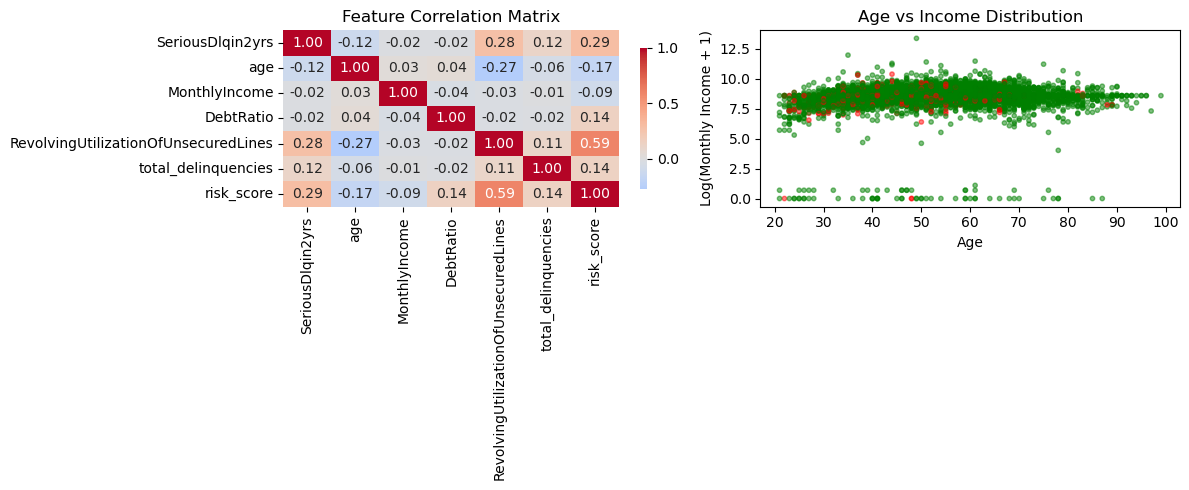

Key Risk Factors:
• Severe delinquency history: 41.6% default rate
• Maxed out credit utilization: 22.9% default rate
• Overall baseline rate: 6.7%


In [7]:
# Correlation Analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Feature correlation heatmap
ax1 = axes[0]
correlation_cols = ['SeriousDlqin2yrs', 'age', 'MonthlyIncome', 'DebtRatio', 
                   'RevolvingUtilizationOfUnsecuredLines', 'total_delinquencies', 'risk_score']
available_cols = [col for col in correlation_cols if col in df.columns]
corr_matrix = df[available_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Feature Correlation Matrix')

# Income vs Age scatter (sample)
ax2 = axes[1]
sample_size = 5000
sample_idx = np.random.choice(len(df), min(sample_size, len(df)), replace=False)
sample_df = df.iloc[sample_idx]

colors = ['green' if x == 0 else 'red' for x in sample_df['SeriousDlqin2yrs']]
ax2.scatter(sample_df['age'], np.log1p(sample_df['MonthlyIncome']), 
            c=colors, alpha=0.5, s=10)
ax2.set_title('Age vs Income Distribution')
ax2.set_xlabel('Age')
ax2.set_ylabel('Log(Monthly Income + 1)')

plt.tight_layout()
plt.show()

# Key insights summary
print("Key Risk Factors:")
if 'severe_delinquency' in df.columns:
    severe_rate = df[df['severe_delinquency'] == 1]['SeriousDlqin2yrs'].mean()
    print(f"• Severe delinquency history: {severe_rate:.1%} default rate")
if 'maxed_out' in df.columns:
    maxed_rate = df[df['maxed_out'] == 1]['SeriousDlqin2yrs'].mean()
    print(f"• Maxed out credit utilization: {maxed_rate:.1%} default rate")
print(f"• Overall baseline rate: {target.mean():.1%}")

In [ ]:
# Select features (exclude target and temporary columns)
exclude_cols = ['SeriousDlqin2yrs', 'debt_payment_bin'] if 'debt_payment_bin' in df.columns else ['SeriousDlqin2yrs']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].copy()
y = df['SeriousDlqin2yrs'].copy()

print(f"Features: {X.shape[1]}, Samples: {X.shape[0]:,}")
print(f"Default rate: {y.mean():.1%}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]:,}, Test: {X_test.shape[0]:,}")

# Model evaluation function
def evaluate_model(model, X_train_data, X_test_data, y_train, y_test, model_name):
    model.fit(X_train_data, y_train)
    
    # Predictions and probabilities
    y_pred = model.predict(X_test_data)
    y_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    print(f"{model_name}: Accuracy={accuracy:.3f}, AUC={auc:.3f}, F1={f1:.3f}")
    
    return {
        'name': model_name, 'model': model, 'accuracy': accuracy, 'auc': auc,
        'precision': precision, 'recall': recall, 'f1': f1,
        'predictions': y_pred, 'probabilities': y_proba
    }

print("\nTraining models...")

# Train models
models = []

# Logistic Regression
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
models.append(evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"))

# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=-1)
models.append(evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest"))

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss', verbosity=0)
models.append(evaluate_model(xgb_model, X_train, X_test, y_train, y_test, "XGBoost"))

# LightGBM
lgb = LGBMClassifier(random_state=42, n_estimators=100, verbosity=-1, force_col_wise=True)
models.append(evaluate_model(lgb, X_train, X_test, y_train, y_test, "LightGBM"))

# Find best model
best_model = max(models, key=lambda x: x['auc'] if x['auc'] else 0)
print(f"\nBest model: {best_model['name']} (AUC: {best_model['auc']:.3f})")

print("Model training complete!")

Preparing data for modeling...
Features: 25, Samples: 150,000
Default rate: 6.7%
Training: 120,000, Test: 30,000

Training models...
Logistic Regression: Accuracy=0.799, AUC=0.860, F1=0.337
Logistic Regression: Accuracy=0.799, AUC=0.860, F1=0.337
Random Forest: Accuracy=0.935, AUC=0.834, F1=0.244
Random Forest: Accuracy=0.935, AUC=0.834, F1=0.244
XGBoost: Accuracy=0.936, AUC=0.860, F1=0.301
XGBoost: Accuracy=0.936, AUC=0.860, F1=0.301
LightGBM: Accuracy=0.938, AUC=0.868, F1=0.293

Best model: LightGBM (AUC: 0.868)
Model training complete!
LightGBM: Accuracy=0.938, AUC=0.868, F1=0.293

Best model: LightGBM (AUC: 0.868)
Model training complete!


Model Performance Summary:
              Model  Accuracy   AUC  Precision  Recall  F1_Score
Logistic Regression     0.799 0.860      0.216   0.762     0.337
      Random Forest     0.935 0.834      0.560   0.156     0.244
            XGBoost     0.936 0.860      0.562   0.206     0.301
           LightGBM     0.938 0.868      0.605   0.194     0.293


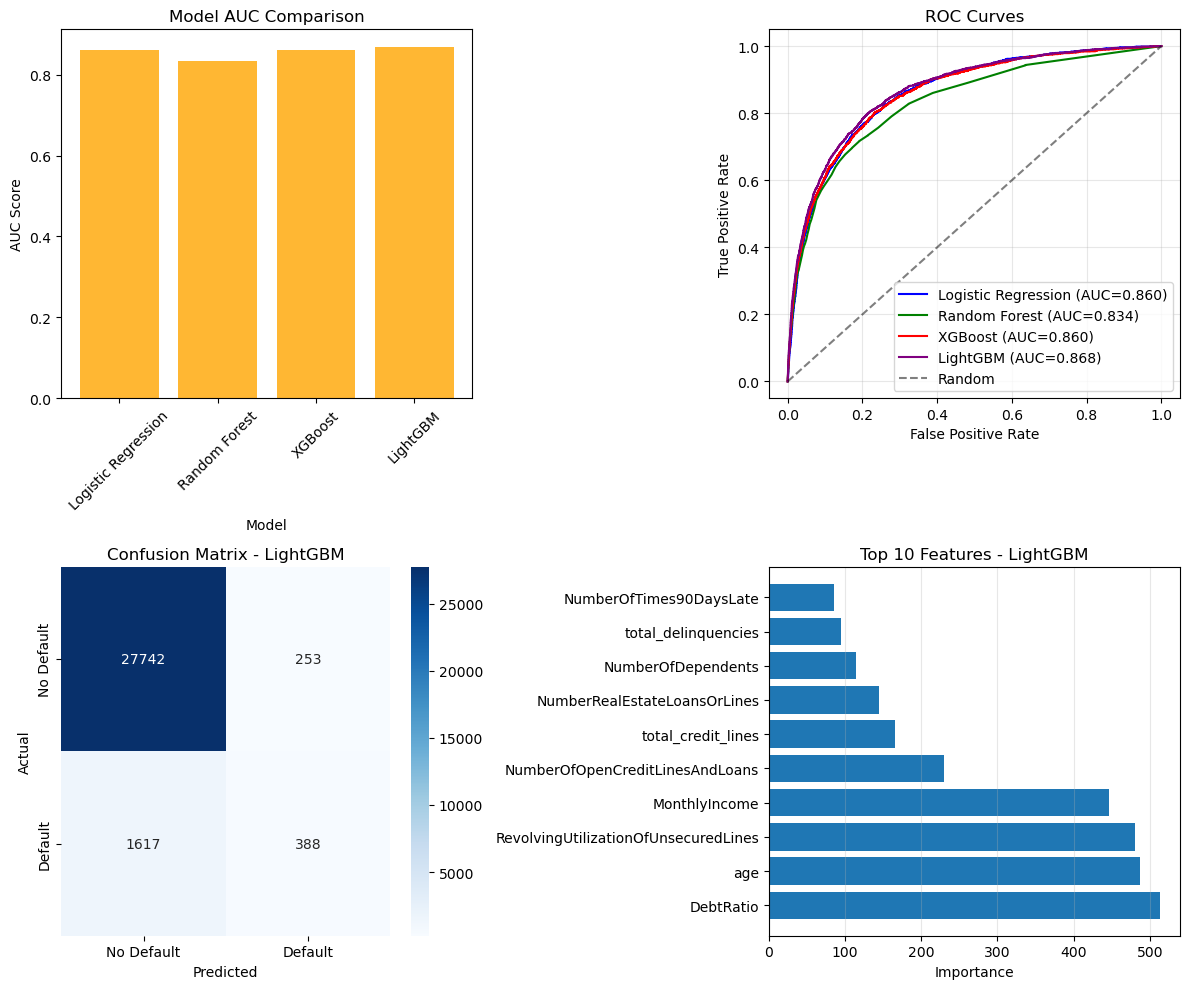

In [9]:
# Model Comparison and Results
comparison_df = pd.DataFrame([{
    'Model': m['name'],
    'Accuracy': m['accuracy'],
    'AUC': m['auc'],
    'Precision': m['precision'],
    'Recall': m['recall'],
    'F1_Score': m['f1']
} for m in models])

print("Model Performance Summary:")
print("=" * 70)
print(comparison_df.round(3).to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Model performance comparison
ax1 = axes[0, 0]
models_names = comparison_df['Model']
x_pos = range(len(models_names))
ax1.bar(x_pos, comparison_df['AUC'], alpha=0.8, color='orange')
ax1.set_xlabel('Model')
ax1.set_ylabel('AUC Score')
ax1.set_title('Model AUC Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_names, rotation=45)

# ROC curves
ax2 = axes[0, 1]
colors = ['blue', 'green', 'red', 'purple']
for i, model_result in enumerate(models):
    if model_result['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, model_result['probabilities'])
        ax2.plot(fpr, tpr, color=colors[i], 
                label=f"{model_result['name']} (AUC={model_result['auc']:.3f})")

ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(alpha=0.3)

# Confusion matrix for best model
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, best_model['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
           xticklabels=['No Default', 'Default'], 
           yticklabels=['No Default', 'Default'])
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title(f'Confusion Matrix - {best_model["name"]}')

# Feature importance (if available)
ax4 = axes[1, 1]
if hasattr(best_model['model'], 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model['model'].feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    ax4.barh(range(len(feature_imp)), feature_imp['importance'])
    ax4.set_yticks(range(len(feature_imp)))
    ax4.set_yticklabels(feature_imp['feature'])
    ax4.set_xlabel('Importance')
    ax4.set_title(f'Top 10 Features - {best_model["name"]}')
    ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Model Performance Comparison

| Model | Accuracy | AUC | Precision | Recall | F1-Score |
|-------|----------|-----|-----------|--------|----------|
| Logistic Regression | 0.799 | 0.860 | 0.216 | 0.762 | 0.337 |
| Random Forest | 0.935 | 0.834 | 0.560 | 0.156 | 0.244 |
| XGBoost | 0.936 | 0.860 | 0.562 | 0.206 | 0.301 |
| LightGBM | 0.938 | 0.868 | 0.605 | 0.194 | 0.293 |

**Key Observations:**
- LightGBM achieved the highest AUC (0.868) and precision (0.605)
- Logistic Regression has the highest recall (0.762) but lowest accuracy
- Tree-based models (RF, XGBoost, LightGBM) show high accuracy but lower recall
- Trade-off between precision and recall is evident across all models

In [11]:
# Final Analysis Summary
print("Analysis Summary")
print("=" * 50)

print(f"\nDataset Characteristics:")
print(f"• Records: {X.shape[0]:,}")
print(f"• Features: {X.shape[1]} (including engineered)")
print(f"• Default rate: {y.mean():.1%}")

print(f"\nKey Risk Factors:")
if 'severe_delinquency' in df.columns:
    severe_rate = df[df['severe_delinquency'] == 1]['SeriousDlqin2yrs'].mean()
    print(f"• Severe delinquency history: {severe_rate:.1%}")
if 'maxed_out' in df.columns:
    maxed_rate = df[df['maxed_out'] == 1]['SeriousDlqin2yrs'].mean()
    print(f"• Maxed out credit utilization: {maxed_rate:.1%}")
if 'risk_score' in df.columns:
    high_risk_rate = df[df['risk_score'] >= 3]['SeriousDlqin2yrs'].mean()
    print(f"• High risk score (3+): {high_risk_rate:.1%}")

print(f"\nBest Model Performance:")
print(f"• Model: {best_model['name']}")
print(f"• AUC: {best_model['auc']:.3f}")
print(f"• Accuracy: {best_model['accuracy']:.1%}")
print(f"• Precision: {best_model['precision']:.1%}")
print(f"• Recall: {best_model['recall']:.1%}")
print(f"• F1-Score: {best_model['f1']:.3f}")

Analysis Summary

Dataset Characteristics:
• Records: 150,000
• Features: 25 (including engineered)
• Default rate: 6.7%

Key Risk Factors:
• Severe delinquency history: 41.6%
• Maxed out credit utilization: 22.9%
• High risk score (3+): 32.4%

Best Model Performance:
• Model: LightGBM
• AUC: 0.868
• Accuracy: 93.8%
• Precision: 60.5%
• Recall: 19.4%
• F1-Score: 0.293
